In [1]:
!pip3 install kaggle tqdm

In [2]:
!kaggle datasets download -d ebrahimelgazar/pixel-art
!unzip -p pixel-art.zip sprites.npy > sprites.npy
!unzip -p pixel-art.zip sprites_labels.npy > sprites_labels.npy

Dataset URL: https://www.kaggle.com/datasets/ebrahimelgazar/pixel-art
License(s): apache-2.0
 94% 81.0M/85.7M [00:01<00:00, 79.0MB/s]
100% 85.7M/85.7M [00:01<00:00, 79.8MB/s]


In [3]:
!curl https://raw.githubusercontent.com/ggonzalesd/diffusion-pixelart/refs/heads/main/m_attention.py --output m_attention.py
!curl https://raw.githubusercontent.com/ggonzalesd/diffusion-pixelart/refs/heads/main/m_convolutional.py --output m_convolutional.py
!curl https://raw.githubusercontent.com/ggonzalesd/diffusion-pixelart/refs/heads/main/m_diffusion.py --output m_diffusion.py
!curl https://raw.githubusercontent.com/ggonzalesd/diffusion-pixelart/refs/heads/main/m_downblock.py --output m_downblock.py
!curl https://raw.githubusercontent.com/ggonzalesd/diffusion-pixelart/refs/heads/main/m_model.py --output m_model.py
!curl https://raw.githubusercontent.com/ggonzalesd/diffusion-pixelart/refs/heads/main/m_tools.py --output m_tools.py
!curl https://raw.githubusercontent.com/ggonzalesd/diffusion-pixelart/refs/heads/main/m_unet.py --output m_unet.py
!curl https://raw.githubusercontent.com/ggonzalesd/diffusion-pixelart/refs/heads/main/m_upblock.py --output m_upblock.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3145  100  3145    0     0   9822      0 --:--:-- --:--:-- --:--:--  9828
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1197  100  1197    0     0   3534      0 --:--:-- --:--:-- --:--:--  3530
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1197  100  1197    0     0   3787      0 --:--:-- --:--:-- --:--:--  3800
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2368  100  2368    0     0   8136      0 --:--:-- --:--:-- --:--:--  8137
  % Total    % Received % Xferd  Average Speed   Tim

In [4]:
import numpy as np
import torch
from torch import nn, optim, Tensor
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from PIL import Image

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [5]:
labels = Tensor(np.load('sprites_labels.npy').argmax(axis=1)).type(torch.long)
labels.shape

torch.Size([89400])

In [6]:
image = np.load('sprites.npy').astype(np.float32) / 255
image = Tensor(image.swapaxes(-1, 1))
image = image * 2 - 1

image.shape

torch.Size([89400, 3, 16, 16])

In [47]:
import math, random
from m_model import Model
from m_diffusion import Diffusion, cosine_schedule, linear_shedule

In [61]:
def genereate_image(model:nn.Module, diffusion:Diffusion, device='cpu'):
  n = 4
  model.eval()
  model.to(device)
  with torch.inference_mode():
    x = torch.randn((n, 3, 16, 16), device=device)
    pbar = tqdm(total=1000, desc=f'Sampling', position=0, colour='yellow')
    pbar.update(1)

    for i in reversed(range(1, 1000)):
      t = (torch.ones(n, device=device) * i).long()
      predicted:Tensor = model(x, t)
      alpha = diffusion.alpha[t][:, None, None, None]
      alpha_hat = diffusion.alpha_hat[t][:, None, None, None]
      beta = diffusion.beta[t][:, None, None, None]
      if i > 1:
        noise = torch.randn_like(x, device=device)
      else:
        noise = torch.zeros_like(x, device=device)
      x = 1 / torch.sqrt(alpha) * (x - ((1-alpha)/(torch.sqrt(1 - alpha_hat)))*predicted) + torch.sqrt(beta)*noise
      pbar.update(1)
    pbar.close()

  x = (x.clamp(-1, 1) + 1) / 2
  x = (x * 255).type(torch.uint8)

  for i in range(4):
    plt.subplot(2, 2, 1+i)
    plt.imshow(x.detach().cpu()[i].swapaxes(0, -1).numpy())
  plt.show()

In [49]:
c_in = 3
c_out = 3
embedding = 256
steps = 1000
categories=5
w_size = 16
h_size = 16

In [71]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
diffusion = Diffusion(steps, linear_shedule(steps).to(DEVICE), device=DEVICE)
DEVICE

device(type='cuda')

In [72]:
model = Model(c_in, c_out, w_size, h_size, steps, categories, embedding, device=DEVICE).to(DEVICE)

In [73]:
dataset = TensorDataset(image, labels)
dl = DataLoader(dataset, batch_size=2*512, shuffle=True, drop_last=True)

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-8)
loss_fn = nn.MSELoss()

Train (11/10):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

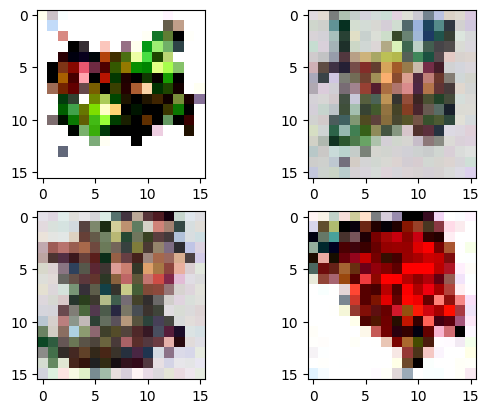

Train (12/10):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

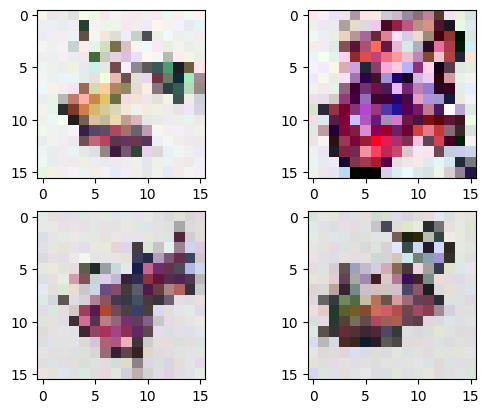

Train (13/10):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

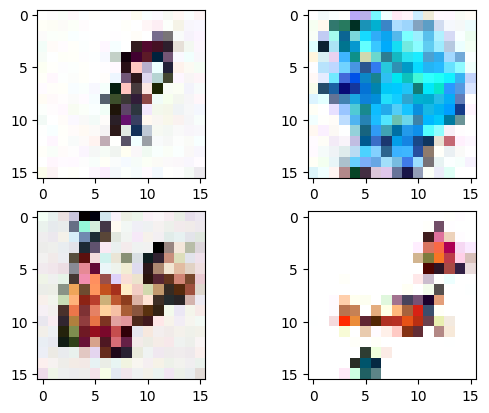

Train (14/10):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

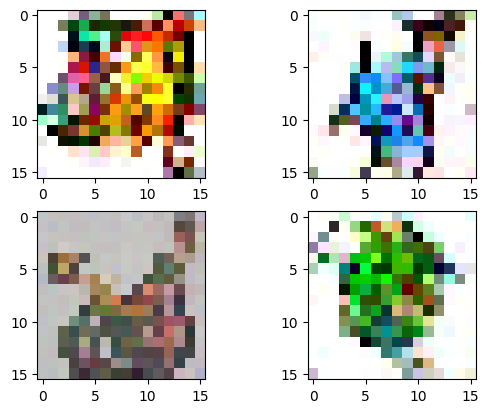

Train (15/10):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

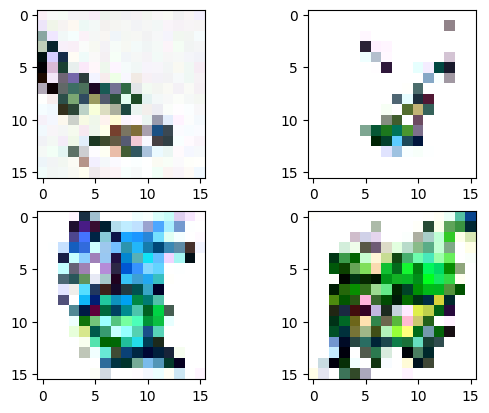

Train (16/10):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

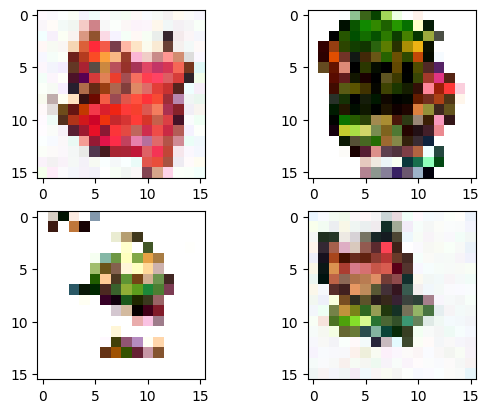

Train (17/10):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

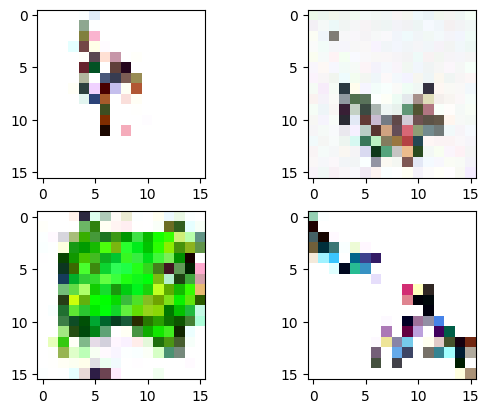

Train (18/10):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

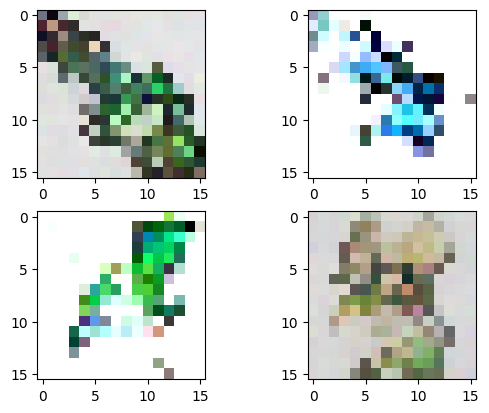

Train (19/10):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

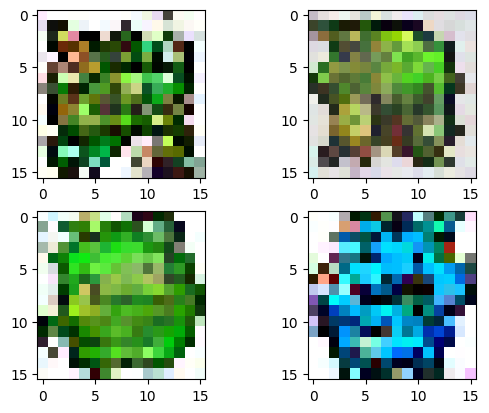

Train (20/10):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

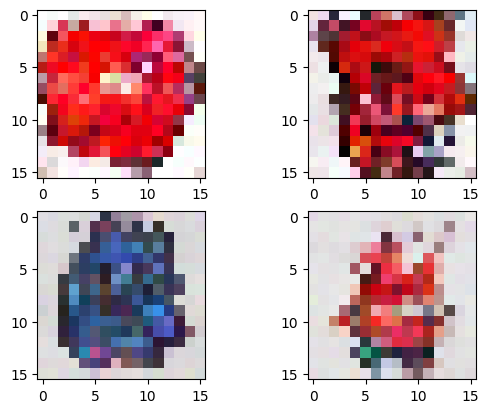

Train (21/10):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

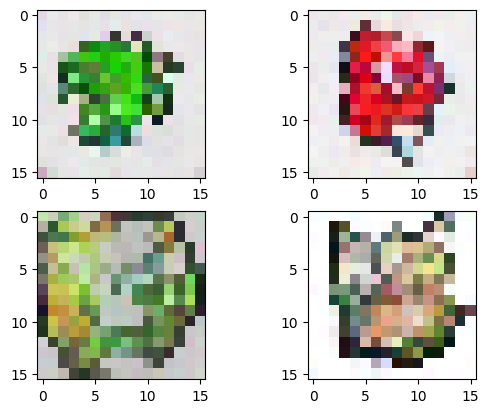

Train (22/10):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

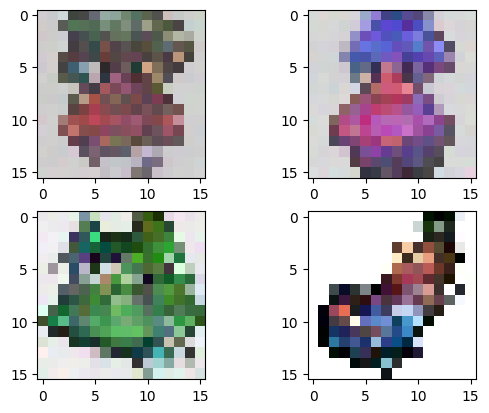

Train (23/10):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

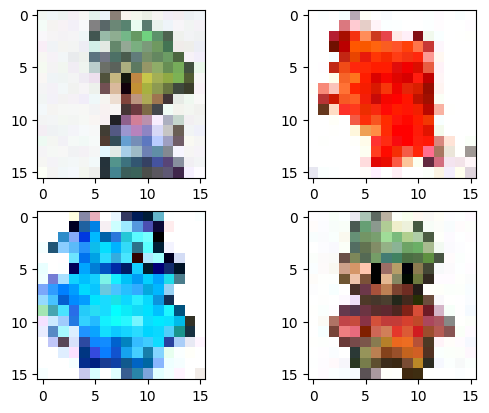

Train (24/10):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

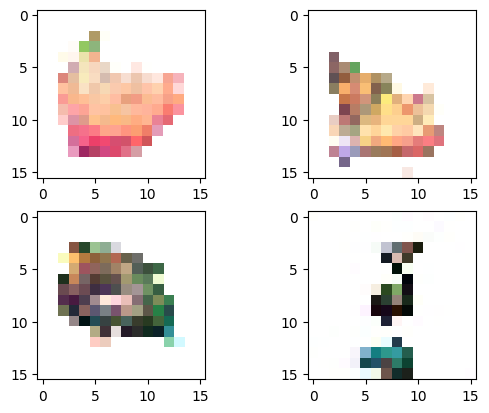

Train (25/10):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

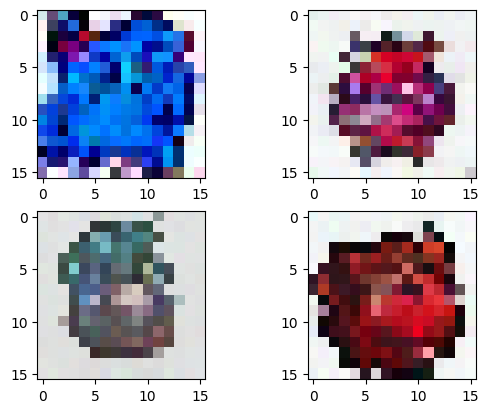

Train (26/10):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

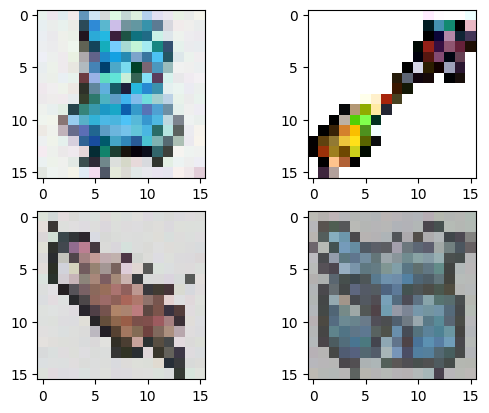

Train (27/10):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

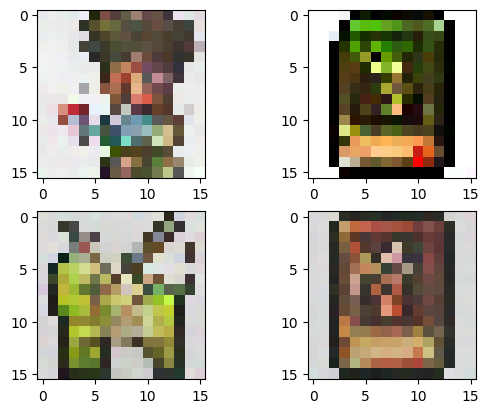

Train (28/10):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

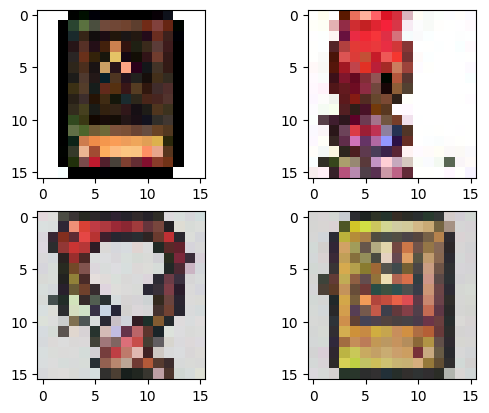

Train (29/10):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

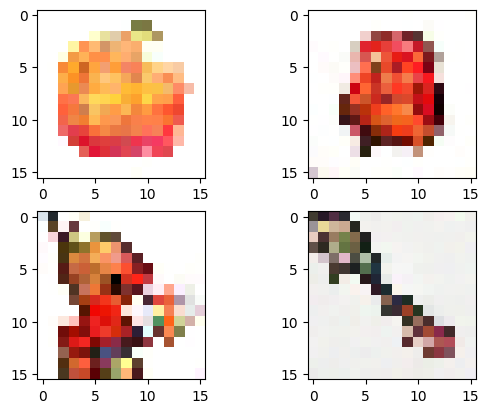

Train (30/10):   0%|          | 0/87 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

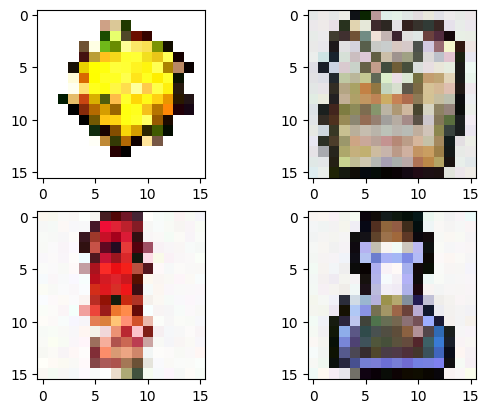

In [75]:
for epoch in range(10, 30):
  loss_total = 0

  pbar = tqdm(total=len(dl), desc=f'Train ({epoch+1}/{10})', position=0, colour='yellow')
  model.train()
  for X, Y in dl:
    X = X.to(DEVICE)
    Y = Y.to(DEVICE)

    t = torch.randint(low=0, high=steps, size=(X.shape[0],), device=DEVICE)
    x_t, noise = diffusion.noise_image(X, t)
    predicted = model(x_t, t, Y if random.random() < 0.1 else None)

    loss:Tensor = loss_fn(noise, predicted)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_total += loss.item() * X.shape[0]

    pbar.set_postfix(MSE=loss.item())
    pbar.update(1)

  loss_total /= len(dl.dataset)

  pbar.set_postfix(MSE=loss_total)
  pbar.close()

  torch.save(model.state_dict(), f'model-{epoch+1}.pt')

  genereate_image(model, diffusion, DEVICE)

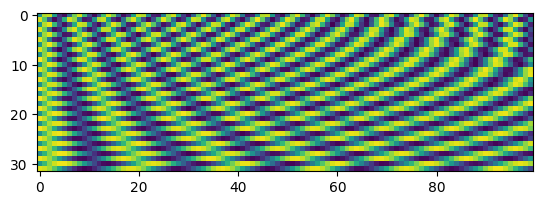

In [84]:
#plt.subplot(3, 1, 1)
#plt.imshow(model.space_emb.weight.detach().cpu().numpy())
#plt.subplot(3, 1, 2)
#plt.imshow(model.category_emb.weight.detach().cpu().numpy())
#plt.subplot(3, 1, 3)
plt.imshow(model.step_emb.weight.detach().cpu().numpy().T[:32,:100])
plt.show()